In [3]:
import numpy as np
import struct
import os
import json
import zipfile
from scipy.optimize import root_scalar

# ---- EDIT THIS ----
zip_path = r'C:\Users\klipk\Downloads\test7_logs\teensy_raw_1553.zip'  # Path to your ZIP file
bin_base = 'teensy_raw_'  # Base file name inside the ZIP

# ---- CONSTANTS: must match Arduino/Python ----
V_REF       = 3.3
ADC_MAX_10  = 1023.0
ADC_MAX_12  = 4095.0
R_REF       = 1000.0

S_HIGH      = 50
S_LOW       = 16000

BYTES_H     = S_HIGH * 2
BYTES_TH    = 4
BYTES_L     = S_LOW * 2
BYTES_TL1   = 4
BYTES_TL2   = 4
BYTES_AG    = 4

TOTAL_BYTES = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL1 + BYTES_TL2 + BYTES_AG

R0 = 1000.0  # Ohms for Pt1000
A = 3.9083e-3
B = -5.775e-7
C_neg = -4.183e-12  # Only used for T < 0

def pt1000_lookup(R_measured):
    """
    Given resistance R in ohms, return the corresponding temperature in °C
    using the inverse of the Callendar–Van Dusen equation for Pt1000.
    """
    def R_of_T(T):
        C = C_neg if T < 0 else 0.0
        return R0 * (1 + A*T + B*T**2 + C*(T - 100)*T**3)

    # Define the root function: R(T) - R_measured = 0
    def residual(T):
        return R_of_T(T) - R_measured

    # Try solving between -200°C and 850°C (valid for Pt1000)
    sol = root_scalar(residual, bracket=[-200, 850], method='brentq')

    if sol.converged:
        return sol.root
    else:
        return None  # Or raise an error if desired


def parse_teensy_bin(raw):
    idx = 0
    vh        = np.frombuffer(raw[idx:idx+BYTES_H],   dtype=np.uint16); idx += BYTES_H
    t_high    = struct.unpack('<I',  raw[idx:idx+BYTES_TH])[0];       idx += BYTES_TH
    vl        = np.frombuffer(raw[idx:idx+BYTES_L],   dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I',  raw[idx:idx+BYTES_TL1])[0];      idx += BYTES_TL1
    totalLow  = struct.unpack('<I',  raw[idx:idx+BYTES_TL2])[0];      idx += BYTES_TL2
    avg_count = struct.unpack('<f',  raw[idx:idx+BYTES_AG])[0]        # float32

    # Compute timing per sample:
    dt_h = t_high / S_HIGH
    dt_l1 = totalLow1 / 1200.0         # First 1200 low-speed samples
    dt_l2 = (totalLow - totalLow1) / (S_LOW - 1200.0)  # Remaining low-speed samples

    t_h = np.arange(S_HIGH) * dt_h
    t_l1 = t_h[-1] + dt_h + np.arange(1200) * dt_l1
    t_l2 = t_l1[-1] + dt_l1 + np.arange(S_LOW - 1200) * dt_l2

    # Convert ADC counts to voltages
    v_h = vh * (V_REF / ADC_MAX_10)
    v_l1 = vl[:1200] * (V_REF / ADC_MAX_12)
    v_l2 = vl[1200:] * (V_REF / ADC_MAX_12)

    # Calculate temperature from thermistor ADC average count
    V_th = avg_count / ADC_MAX_10 * V_REF
    if V_th == 0 or V_th >= V_REF:
        T_C = None
    else:
        R_th = R_REF * V_th / (V_REF - V_th)
        T_C = pt1000_lookup(R_th)

    return t_h, v_h, t_l1, v_l1, t_l2, v_l2, T_C

# --- Load all data from ZIP ---
all_times = []
all_voltages = []
all_temperatures = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    bin_files = [f for f in zip_ref.namelist() if f.startswith(bin_base) and f.endswith('.bin')]

    for fname in bin_files:
        info = zip_ref.getinfo(fname)
        if info.file_size != TOTAL_BYTES:
            print(f"Skipping {fname}: wrong size ({info.file_size} bytes)")
            continue
        with zip_ref.open(fname) as f:
            raw = f.read()
            try:
                t_h, v_h, t_l1, v_l1, t_l2, v_l2, T_C = parse_teensy_bin(raw)
                t_all = np.concatenate((t_h, t_l1, t_l2))
                v_all = np.concatenate((v_h, v_l1, v_l2))
                all_times.append(t_all)
                all_voltages.append(v_all)
                all_temperatures.append(T_C)
                print(f"Loaded {fname} at T = {T_C:.2f}°C")
            except Exception as e:
                print(f"Skipping {fname}: {e}")

# --- Bin by temperature (nearest 5°C) and average ---
delta_T = 5
binned = {}

for t, v, T in zip(all_times, all_voltages, all_temperatures):
    if T is None:
        continue
    T_bin = delta_T * round(T / delta_T)
    if T_bin not in binned:
        binned[T_bin] = {'times': [], 'voltages': [], 'temps': []}
    binned[T_bin]['times'].append(t)
    binned[T_bin]['voltages'].append(v)
    binned[T_bin]['temps'].append(T)

results = []
for T_bin in sorted(binned.keys()):
    times_stack = np.stack(binned[T_bin]['times'])
    volts_stack = np.stack(binned[T_bin]['voltages'])
    temps = binned[T_bin]['temps']

    t_avg = np.mean(times_stack, axis=0)
    v_avg = np.mean(volts_stack, axis=0)
    T_avg = np.mean(temps)

    results.append((t_avg, v_avg, T_avg))
    print(f"Binned {len(temps)} runs near {T_bin}°C, average T = {T_avg:.2f}°C")

# Now results contains averaged time, voltage, and temperature per 5°C bin


Loaded teensy_raw_1553.bin at T = -78.09°C
Loaded teensy_raw_1552.bin at T = -78.71°C
Loaded teensy_raw_1551.bin at T = -78.91°C
Loaded teensy_raw_1550.bin at T = -79.57°C
Loaded teensy_raw_1549.bin at T = -80.19°C
Loaded teensy_raw_1548.bin at T = -80.85°C
Loaded teensy_raw_1547.bin at T = -81.37°C
Loaded teensy_raw_1546.bin at T = -81.56°C
Loaded teensy_raw_1545.bin at T = -81.56°C
Loaded teensy_raw_1544.bin at T = -81.62°C
Loaded teensy_raw_1543.bin at T = -81.91°C
Loaded teensy_raw_1542.bin at T = -82.74°C
Loaded teensy_raw_1541.bin at T = -83.55°C
Loaded teensy_raw_1540.bin at T = -84.23°C
Loaded teensy_raw_1539.bin at T = -84.66°C
Loaded teensy_raw_1538.bin at T = -85.02°C
Loaded teensy_raw_1537.bin at T = -85.72°C
Loaded teensy_raw_1536.bin at T = -86.55°C
Loaded teensy_raw_1535.bin at T = -87.37°C
Loaded teensy_raw_1534.bin at T = -88.23°C
Loaded teensy_raw_1533.bin at T = -88.92°C
Loaded teensy_raw_1532.bin at T = -89.58°C
Loaded teensy_raw_1531.bin at T = -90.22°C
Loaded teen

C:\Users\klipk\AppData\Local\Temp\ipykernel_12676\1640065486.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e6)


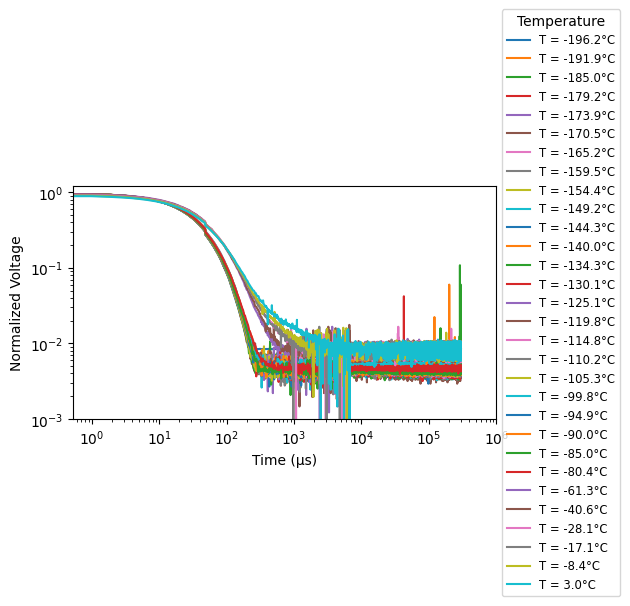

In [4]:
import matplotlib.pyplot as plt

# Plot all bins with T < -30°C (adjust as needed)
for tgg, Vgg, Tgg in results:
    tgg = np.asarray(tgg).flatten()
    Vgg = np.asarray(Vgg).flatten()
    if Tgg < 10:
        plt.plot(tgg, Vgg / 3.3, label=f'T = {Tgg:3.1f}°C')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 1e6)
plt.ylim(1e-3, 1.2)
plt.xlabel("Time (μs)")
plt.ylabel("Normalized Voltage")
plt.legend(title="Temperature", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

In [25]:
# Focus on the critical temperature range for sucrose
plt.figure(figsize=(12, 8))

# Plot only temperatures near expected Tg (-32 to -40°C)
for ds_name, ds in data["datasets"].items():
    T = ds["temperature"]
    if -50 < T < -20:  # Focus on glass transition range
        x = np.array(ds["x"])
        y = np.array(ds["y"]) / np.array(ds["y"])[0]
        plt.plot(x, y, label=f'T = {T:.0f}°C', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time (μs)')
plt.ylabel('Normalized Signal')
plt.title('50% Sucrose Solution - Glass Transition Region')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

KeyError: 'datasets'

<Figure size 1200x800 with 0 Axes>

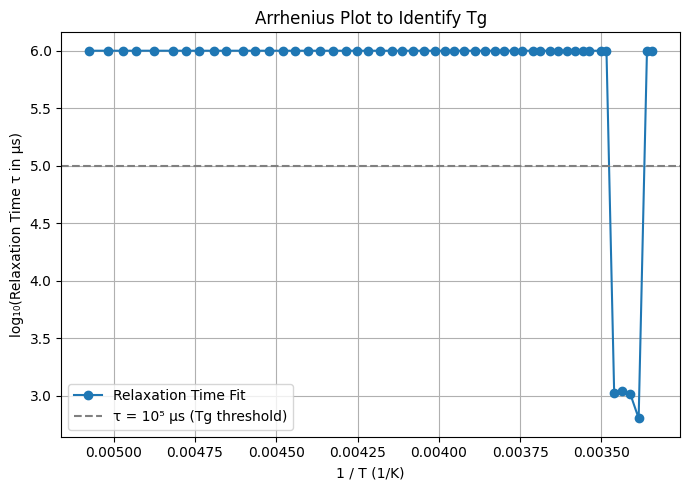

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import struct
import zipfile

# === CONFIG ===
zip_path = r'C:\Users\klipk\Downloads\test7_logs\teensy_raw_3931.zip'
bin_base = 'teensy_raw_'
delta_T = 2

# === CONSTANTS ===
V_REF = 3.3
ADC_MAX_10 = 1023.0
ADC_MAX_12 = 4095.0
R_REF = 1000.0
S_HIGH = 50
S_LOW = 16000
BYTES_H = S_HIGH * 2
BYTES_TH = 4
BYTES_L = S_LOW * 2
BYTES_TL1 = 4
BYTES_TL2 = 4
BYTES_AG = 4
TOTAL_BYTES = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL1 + BYTES_TL2 + BYTES_AG

def pt1000_lookup(R):
    T_ref = np.array([-79, -70, -60, -50, -40, -30,
                      -20, -10, 0, 10, 20, 30])
    R_ref = np.array([687.30, 723.30, 763.30, 803.10,
                      842.70, 882.20, 921.60, 960.90,
                      1000.00, 1039.00, 1077.90, 1116.70])
    return np.interp(R, R_ref, T_ref)

def parse_teensy_bin(raw):
    idx = 0
    vh = np.frombuffer(raw[idx:idx+BYTES_H], dtype=np.uint16); idx += BYTES_H
    t_high = struct.unpack('<I', raw[idx:idx+BYTES_TH])[0]; idx += BYTES_TH
    vl = np.frombuffer(raw[idx:idx+BYTES_L], dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I', raw[idx:idx+BYTES_TL1])[0]; idx += BYTES_TL1
    totalLow = struct.unpack('<I', raw[idx:idx+BYTES_TL2])[0]; idx += BYTES_TL2
    avg_count = struct.unpack('<f', raw[idx:idx+BYTES_AG])[0]

    dt_h = t_high / S_HIGH
    dt_l1 = totalLow1 / 1200.0
    dt_l2 = (totalLow - totalLow1) / (S_LOW - 1200.0)

    t_h = np.arange(S_HIGH) * dt_h
    t_l1 = t_h[-1] + dt_h + np.arange(1200) * dt_l1
    t_l2 = t_l1[-1] + dt_l1 + np.arange(S_LOW - 1200) * dt_l2

    v_h = vh * (V_REF / ADC_MAX_10)
    v_l1 = vl[:1200] * (V_REF / ADC_MAX_12)
    v_l2 = vl[1200:] * (V_REF / ADC_MAX_12)

    V_th = avg_count / ADC_MAX_10 * V_REF
    if V_th == 0 or V_th >= V_REF:
        T_C = None
    else:
        R_th = R_REF * V_th / (V_REF - V_th)
        T_C = pt1000_lookup(R_th)

    t_all = np.concatenate((t_h, t_l1, t_l2))
    v_all = np.concatenate((v_h, v_l1, v_l2))

    return t_all, v_all, T_C

# === Load and bin ===
all_times, all_volts, all_temps = [], [], []
with zipfile.ZipFile(zip_path, 'r') as zf:
    bin_files = [f for f in zf.namelist() if f.startswith(bin_base) and f.endswith('.bin')]
    for fname in bin_files:
        info = zf.getinfo(fname)
        if info.file_size != TOTAL_BYTES:
            continue
        with zf.open(fname) as f:
            try:
                t, v, T = parse_teensy_bin(f.read())
                if T is not None:
                    all_times.append(t)
                    all_volts.append(v)
                    all_temps.append(T)
            except Exception:
                continue

binned = {}
for t, v, T in zip(all_times, all_volts, all_temps):
    T_bin = delta_T * round(T / delta_T)
    binned.setdefault(T_bin, {'times': [], 'voltages': [], 'temps': []})
    binned[T_bin]['times'].append(t)
    binned[T_bin]['voltages'].append(v)
    binned[T_bin]['temps'].append(T)

results = []
for T_bin in sorted(binned):
    times_stack = np.stack(binned[T_bin]['times'])
    volts_stack = np.stack(binned[T_bin]['voltages'])
    T_avg = np.mean(binned[T_bin]['temps'])
    t_avg = np.mean(times_stack, axis=0)
    v_avg = np.mean(volts_stack, axis=0)
    results.append((t_avg, v_avg, T_avg))

# === Fit relaxation curves ===
def stretched_exp(t, tau, beta):
    return np.exp(- (t / tau) ** beta)

relaxation_times = []
temperatures_K = []

for t, V, T_C in results:
    T_K = T_C + 273.15

    # Detect nearly flat voltage = glassy
    if np.std(V[-1000:]) < 0.001:
        # Flat tail — likely glassy: assign long τ
        tau = 1e6  # 1 second in μs
        beta = 0.6
    else:
        try:
            popt, _ = curve_fit(stretched_exp, t, V, p0=(1e3, 0.7), bounds=([1, 0.1], [1e6, 1.0]))
            tau, beta = popt
        except Exception:
            tau = 1e6  # fallback for poor fit
            beta = 0.6

    relaxation_times.append(tau)
    temperatures_K.append(T_K)

# === Plot Arrhenius τ(T) ===
inv_T = 1 / np.array(temperatures_K)
log_tau = np.log10(relaxation_times)

plt.figure(figsize=(7, 5))
plt.plot(inv_T, log_tau, 'o-', label="Relaxation Time Fit")
plt.axhline(np.log10(1e5), color='gray', linestyle='--', label="τ = 10⁵ μs (Tg threshold)")
plt.xlabel("1 / T (1/K)")
plt.ylabel("log₁₀(Relaxation Time τ in μs)")
plt.title("Arrhenius Plot to Identify Tg")
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()
